<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# 06 Embeddings: Representación de texto en Deep Learning


Basado en:

- [Pretrained Word Embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/)
- [Starsconf embeddings](https://github.com/mquezada/starsconf2018-word-embeddings)
- [Spanish word2vect](https://github.com/aitoralmeida/spanish_word2vec)
- [Spanish word embeddings](https://github.com/dccuchile/spanish-word-embeddings)

## Setup

In [ ]:
import os

# Only the TensorFlow backend supports string inputs.
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import numpy as np
import tensorflow.data as tf_data
import keras
from keras import layers

# Preliminar

### 1.3.1 Detección de correos SPAM

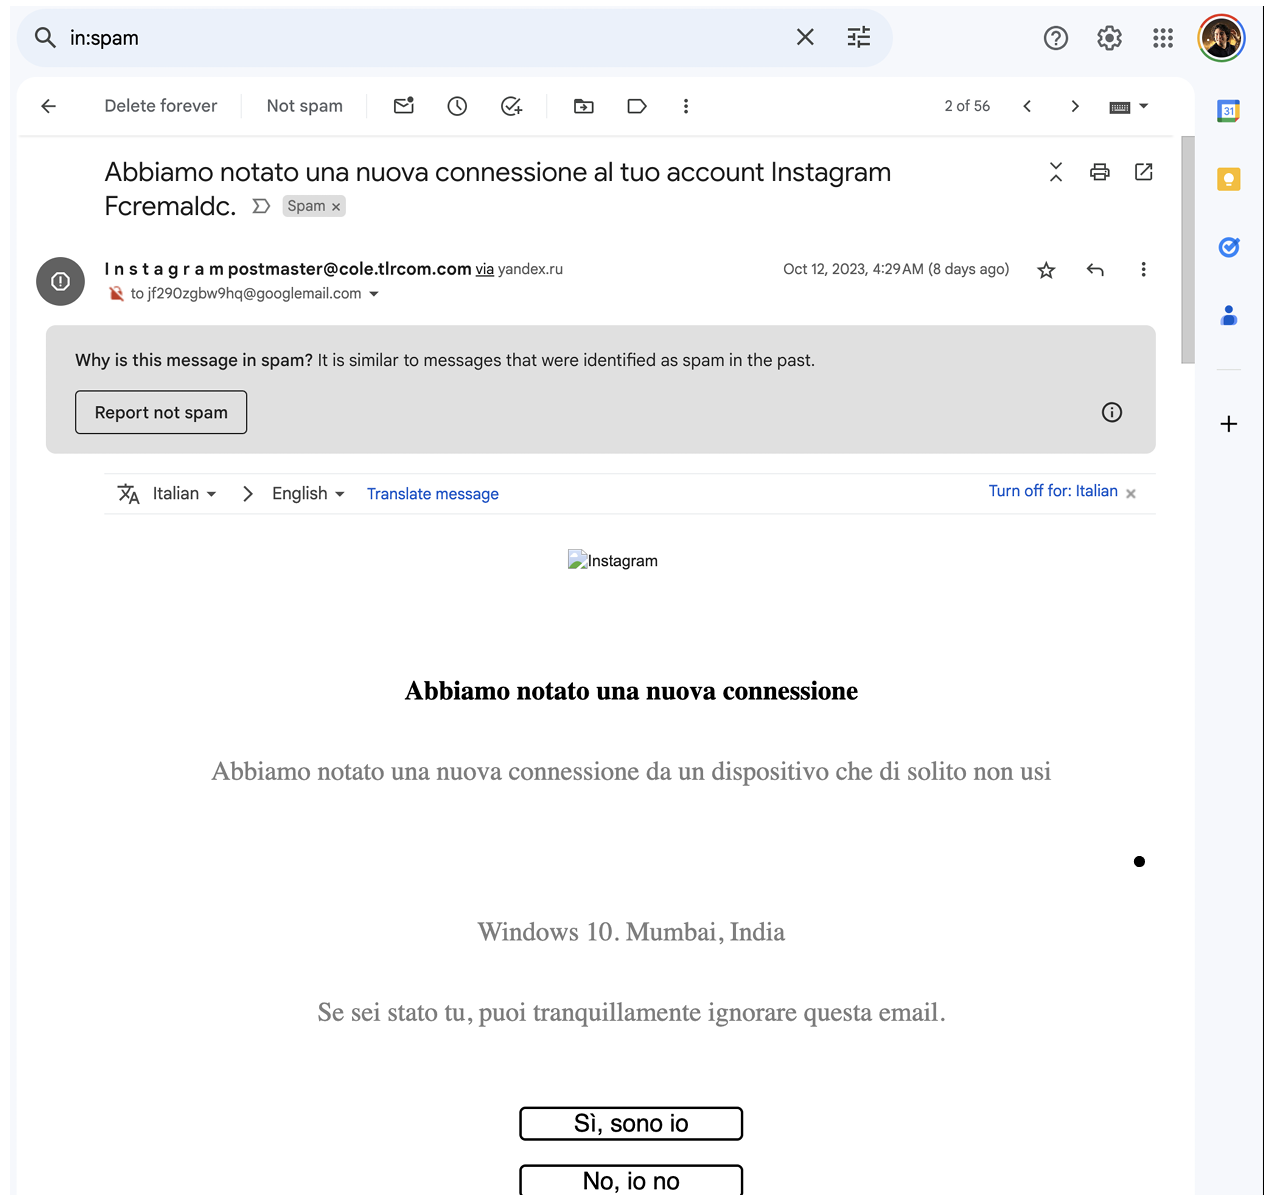

1. **Problema:** Entender si un correos electrónico es ”spam” o ”no spam”.
1. **función?**: 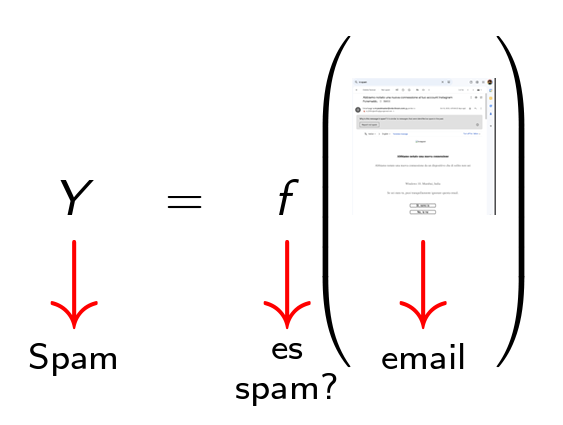
1. Cómo definir la **representación**?: Defino $X$ como el conjunto de secuencias que representan documentos de texto.
$$ X = \{x_1, x_2, x_3, \ldots, x_N\} $$
    - Donde:
        1. $x_i$ representa una secuencia de caracteres arbitraria.
        1. $N$ es el número de secuencias disponibles.

    - Discusión
        1. Cada $x_i$ puede contener palabras, frases o caracteres que conforman el contenido del documento.
        1. El objetivo de la función es etiquetar cada $x_i$ como "spam" o "no spam" según su contenido.


Es fácil saber el rango de la función $$f(x_i) \in \{ spam, no\;\;spam \}$$

Ahora, supongamos que intentamos representar todas las oraciones y de alguna manera obtenemos $f$

1. $f(\textbf{Abbiamo notato una nuova connessione}) = spam$
1. $f(\textbf{Abbiamo notato una nuova}) = spam$
1. $\cdots$
1. $f(\textbf{Abbiamo})=?$

Buscamos resolver el mismo problema pero se pueden tener muchos enfoques:

1. **Diccionario de Palabras:** Se tiene un diccionario que asigna cada palabra a un índice único.
$$ \text{Diccionario: } w_i \rightarrow i $$
1. **Matriz de Embedding:** Se utiliza una matriz de embedding para representar cada palabra como un vector de características.
$$\text{Embedding de } w_i: \vec{v}_i \in \mathbb{R}^d $$
  - Ejemplo: Si \(d = 3\) (vectores tridimensionales), el embedding de la palabra "manzana" puede ser representado como $$\vec{v}_{\text{manzana}} = [0.2, 0.8, 0.5]$$.
  - No solo eso, en el futuro podremos hacer:
  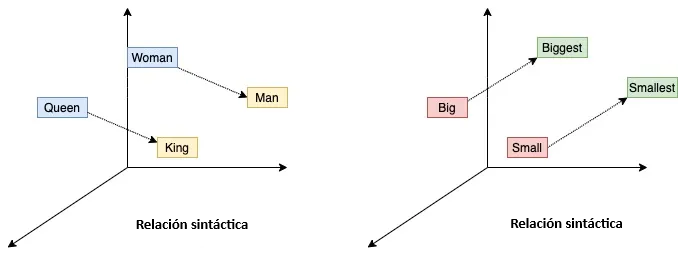

  
[Nikhil Birajdar]([https://towardsdatascience.com/word2vec-research-paper-explained-205cb7eecc30)

# Transformers: De Tokenizers a Embeddings

Antes de usar cualquier modelo de Transformers, necesitamos convertir el texto en tokens (ítems numéricos entendibles por el modelo). Esto lo hace un **tokenizer**.

#### Tipos comunes de tokenización:

- **Word-level**: divide por palabras (`["Hola", "mundo"]`)
- **Subword-level**: divide palabras en fragmentos (`["Ho", "##la", "mundo"]`)
- **Character-level**: divide en caracteres (`["H", "o", "l", "a"]`)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
text = "Hola mundo"
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)
ids = tokenizer.encode(text)
print("Token IDs:", ids)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokens: ['Ho', '##la', 'mundo']
Token IDs: [101, 20220, 10330, 13137, 102]


##  ¿Qué significa el `##` en los tokens?

Cuando usas un tokenizer como el de BERT (`WordPiece`), se intenta dividir el texto en las unidades más comunes posibles. Si una palabra completa no está en el vocabulario, se parte en fragmentos que sí están.

El prefijo `##` indica que ese token es una continuación (sufijo) de la palabra anterior, no el comienzo de una nueva palabra.

### ¿Por qué se hace esto?

1. Reduce el tamaño del vocabulario: no hace falta guardar todas las palabras del idioma.
1. Maneja palabras desconocidas: si una palabra no está, probablemente sus fragmentos sí.
1. Permite representar palabras nuevas o raras, como recomiéndamelo, sin que el modelo se pierda.

Esto es muy útil en lenguajes con alta morfología, como el español. Por ejemplo:

Cada fragmento tiene sentido en sí mismo y permite al modelo generalizar sobre prefijos, raíces y sufijos.

In [ ]:
tokenizer.tokenize("terrateniente")

['terra', '##teni', '##ente']

In [ ]:
tokenizer.tokenize("prehistoria")

['pre', '##his', '##toria']

In [ ]:
tokenizer.tokenize("histología")

['his', '##tol', '##ogía']

Etimológicamente la palabra histología proviene del griego histos que significa tejidos y logos que significa estudio o ciencia de; no es más que la ciencia de los tejidos.

## Interpretación semántica

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
# 1. Cargar modelo y tokenizer en español
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 2. Lista de palabras a comparar
words = [
    "amor", "odio", "felicidad", "tristeza",
    "computadora", "internet",
    "perro", "gato",
    "hospital", "médico", "ingeniero", "matemático",
     "España", "Italia", "Gran Bretaña", "Madrid",
    "AS Roma", "Real Madrid", "Liverpool", "Manchester City",
    "Alan Turing", "Albert Einstein", "Giorgio Parisi",
    "Oasis", "The Beatles", "Maneskin"
    ]

# 3. Obtener embeddings de la token [CLS] para cada palabra
def get_word_embedding(word):
    tokens = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs.last_hidden_state[0]
    return embeddings.mean(dim=0).numpy()  # embedding de la [CLS] token

In [ ]:
embeddings = np.array([get_word_embedding(w) for w in words])

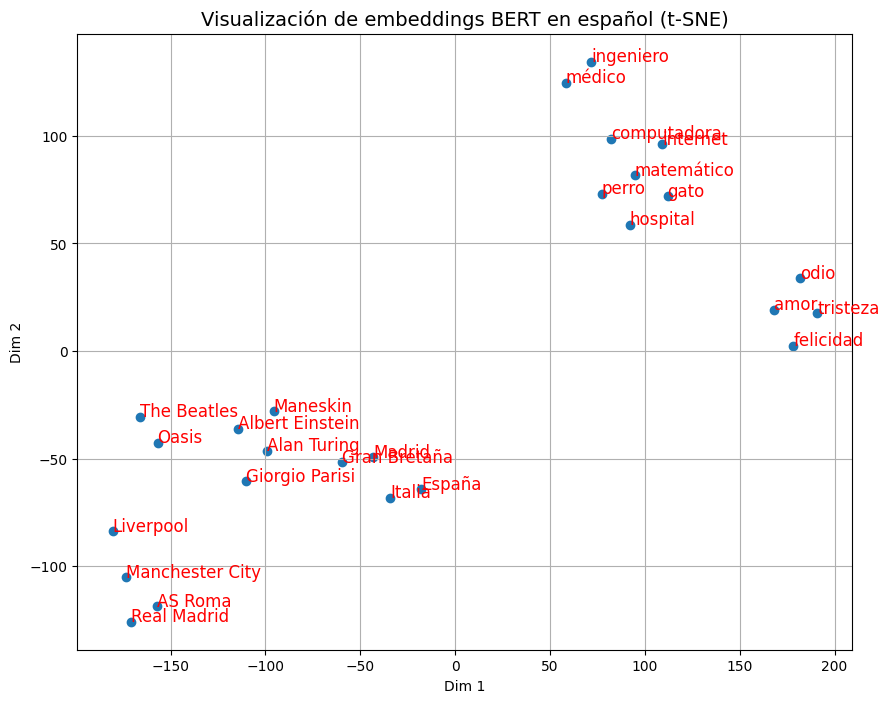

In [ ]:
# 4. Reducir a 2D (primero con PCA, luego t-SNE para mejor separación)
pca = PCA(n_components=5, random_state=42).fit_transform(embeddings)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced = tsne.fit_transform(pca)

# 5. Graficar
plt.figure(figsize=(10, 8))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 0], reduced[i, 1]), fontsize=12, c="red")

plt.title("Visualización de embeddings BERT en español (t-SNE)", fontsize=14)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

## Operaciones sobre embeddings

In [ ]:
# Descargar el archivo con los vectores
!wget -q http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.100k.vec.gz
!gzip -d -q fasttext-sbwc.100k.vec.gz

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 re

In [ ]:
# importa las librerías necesarias para este taller
import numpy as np
import logging

from numpy.linalg import norm
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report, accuracy_score

logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

In [ ]:
we = KeyedVectors.load_word2vec_format('fasttext-sbwc.100k.vec', limit=100000)

### Ejemplo 1: Hombre + dirección * norm(Reina - Mujer)

In [ ]:
# 2. Lista de palabras a comparar
words = [
  "rey", "hombre", "mujer", "reina"
]


In [ ]:
base = [we[w.lower()] for w in words]

In [ ]:
words.append("Hombre + Dirección * norm(Reina - Mujer)")
# Dirección: de hombre a rey
direccion = we["rey"] - we["hombre"]

# Magnitud: distancia entre mujer y reina
magnitud = np.linalg.norm(we["reina"] - we["mujer"])

# Dirección normalizada (unitaria)
direccion_unitaria = direccion / np.linalg.norm(direccion)

# Trasladar desde mujer usando esa dirección y magnitud
vector_resultante = we["hombre"] + magnitud * direccion_unitaria
base.append(vector_resultante)

In [ ]:
embeddings = np.array(base)

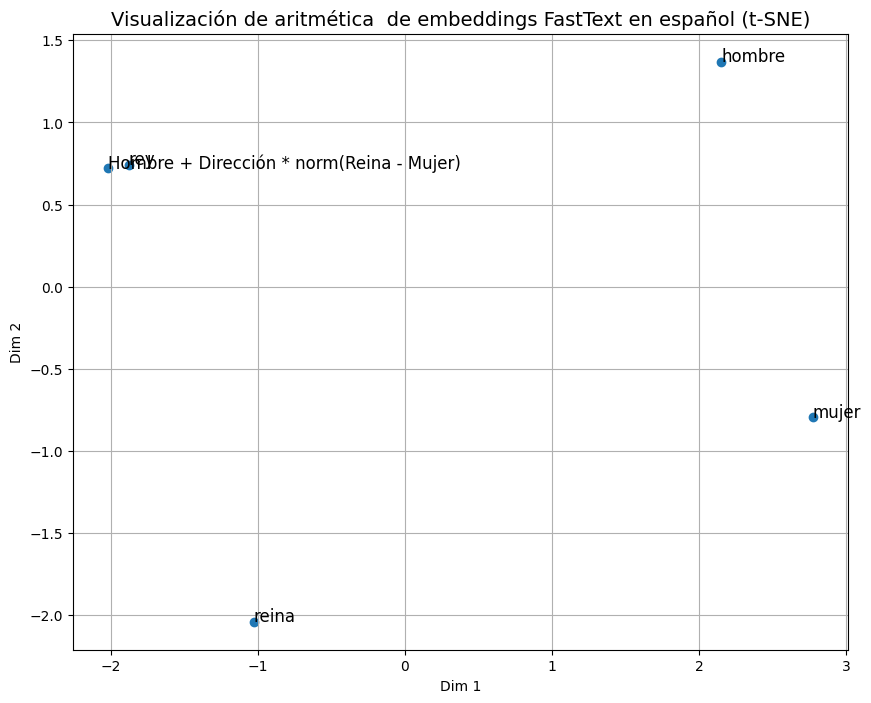

In [ ]:
pca = PCA(n_components=2).fit_transform(embeddings)
reduced = pca

# 5. Graficar
plt.figure(figsize=(10, 8))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 0], reduced[i, 1]), fontsize=12)

plt.title("Visualización de aritmética  de embeddings FastText en español (t-SNE)", fontsize=14)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

### Ejemplo 2: Capitales

In [ ]:
# 2. Lista de palabras a comparar
words = [
  "Roma", "Madrid", "España", "Italia"
]


In [ ]:
base = [we[w.lower()] for w in words]

In [ ]:
words.append("Italia ~ Roma + Dirección * norm(España - Madrid)")
# Dirección: de roma a italia
direccion = we["italia"] - we["roma"]

# Magnitud: distancia entre madrid y españa
magnitud = np.linalg.norm(we["españa"] - we["madrid"])

# Dirección normalizada (unitaria)
direccion_unitaria = direccion / np.linalg.norm(direccion)

# Trasladar desde roma usando la dirección y magnitud
vector_resultante = we["roma"] + magnitud * direccion_unitaria
base.append(vector_resultante)

In [ ]:
embeddings = np.array(base)

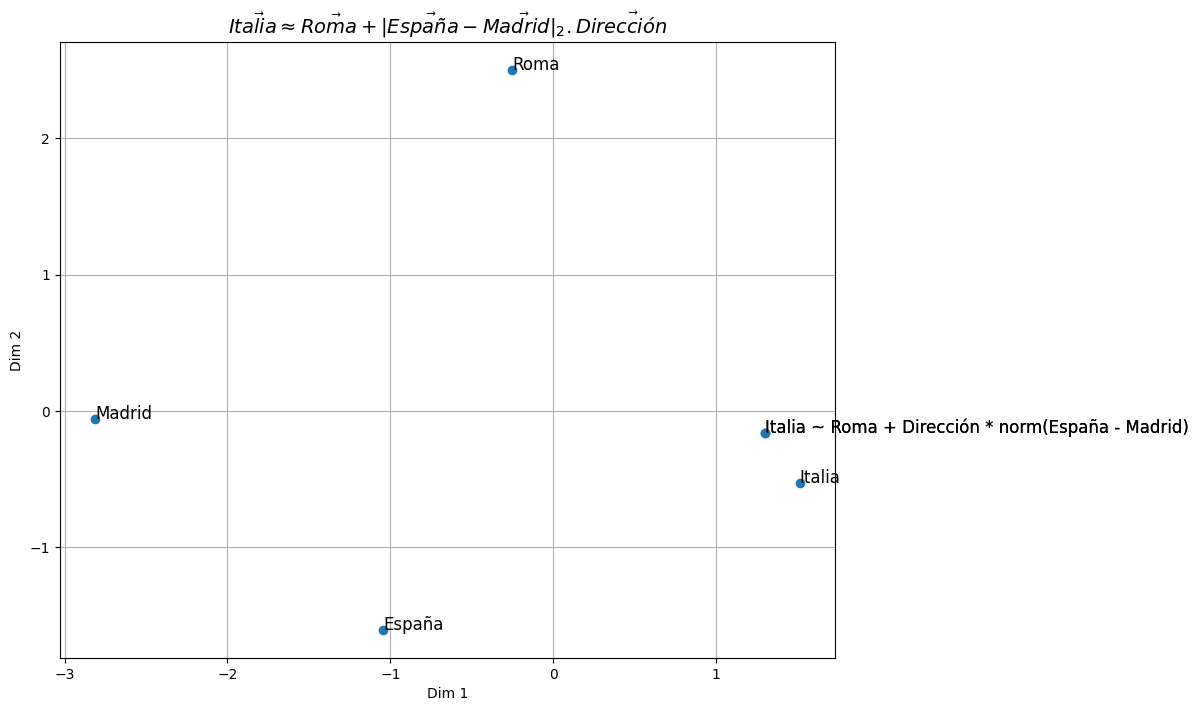

In [ ]:
pca = PCA(n_components=2).fit_transform(embeddings)
reduced = pca

# 5. Graficar
plt.figure(figsize=(10, 8))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 0], reduced[i, 1]), fontsize=12)

plt.title(r"$\vec{Italia} \approx  \vec{Roma} + |\vec{España} - \vec{Madrid}|_2 . \vec{Dirección}  $", fontsize=14)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

### Distancia coseno para modelos BERT

In [ ]:
# Obtener vectores
madrid_vec = get_word_embedding("Madrid")
futbol_vec = get_word_embedding("fútbol")
real_madrid_vec = get_word_embedding("Real Madrid")

# Vector compuesto
compuesto = madrid_vec + futbol_vec

# Comparar similitud (coseno)
from sklearn.metrics.pairwise import cosine_similarity

similitud = cosine_similarity([compuesto], [real_madrid_vec])[0][0]
print(f"Similitud coseno entre 'Madrid + fútbol' y 'Real Madrid': {similitud:.3f}")

Similitud coseno entre 'Madrid + fútbol' y 'Real Madrid': 0.837


## Descarga del dataset de compras de la Universidad de Chile

In [ ]:
# Descargar los datos que usaremos en el taller
!wget -q http://users.dcc.uchile.cl/~mquezada/data-compras.zip
!unzip -q data-compras.zip


In [ ]:
compras = []
with open('dataset_compras.tsv') as f:
  for line in f:
    glosa, clase = line[:-1].split('\t')
    compras.append((glosa, int(clase)))

# ejemplos
compras[100:110]

[('pisco alto del carmen 750 ml', 1),
 ('crema bose tacndimus para tratamiento dermatologico (30grs)', 4),
 ('poleras de mujer nime', 2),
 ('examenes mamarios', 4),
 ('recarga bip', 5),
 ('viaje taxi trabajo - casa', 5),
 ('noche', 4),
 ('resperidona (ansiedad) o dagotil', 4),
 ('cuello de genero de mujer', 2),
 ('boletos a villa alemana ida y vuelta', 5)]

In [ ]:
clases = []
with open('clases.tsv') as f:
  clases = [line[:-1] for line in f]

clases

['alimentos comida bebida carne pollo jugo',
 'alcohol cigarrillo tabaco',
 'ropa de vestir calzado zapatos vestidos',
 'muebles hogar aseo herramienta',
 'salud medicamento hospital',
 'transporte bus avion automóvil',
 'comunicaciones teléfono celular']

## Vectores para frases y  similitud

Para convertir una lista de palabras en un vector, simplemente sumamos los vectores, y luego normalizamos el vector resultante:

In [ ]:
samples = []
labels = []
class_names = clases

for t, c in compras:
    samples.append(t)
    labels.append(c)

print("Classes:", class_names)
print("Number of samples:", len(samples))

Classes: ['alimentos comida bebida carne pollo jugo', 'alcohol cigarrillo tabaco', 'ropa de vestir calzado zapatos vestidos', 'muebles hogar aseo herramienta', 'salud medicamento hospital', 'transporte bus avion automóvil', 'comunicaciones teléfono celular']
Number of samples: 572080


## Shuffle and split the data into training & validation sets

In [ ]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

## Creando el índice del vocabulario

Usemos `TextVectorization` para indexar el vocabulario del conjunto de datos.
Luego, usaremos la misma instancia de capa para vectorizar las muestras.

Nuestra capa solo considerará las primeras 20000 palabras y truncará o rellenará las secuencias para que tengan una longitud de 200 tokens.

Este parámetro puede ser modificado, a mayor salida de secuencia (hasta la dimensión de los embeddings) mejores representaciones.

In [ ]:
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf_data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

Podemos obtener el vocabulario con `vectorizer.get_vocabulary()`. E imprimir el top 5 de palabras

In [ ]:
print("\n".join(map(lambda x: str(x[0] + 1)  + ": " + "'" + x[1] + "'",  zip(range(5),  vectorizer.get_vocabulary()[:5]))))

1: ''
2: '[UNK]'
3: 'de'
4: 'para'
5: 'en'


Vectoricemos la siguiente oración:

In [ ]:
output = vectorizer([["de colmax 125 mg, 10 comprimidos"]])
output.numpy()[0, :5]

array([   2, 7906,  546,   19,   33])

Como puede ver, "de" se representa como "2". ¿Por qué no como 0, dado que "de" fue la primera palabra del vocabulario? Esto se debe a que el índice 0 está reservado para el relleno y el índice 1 para los tokens "fuera del vocabulario" o `[UNK]`.

Aquí hay un diccionario que asigna las palabras a sus índices:

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

Como pueden ver, obtenemos exactamente el mismo encoding de la oración de prueba:

In [ ]:
test = "de colmax 125 mg, 10 comprimidos".replace(",", "").split()
print(test)
[word_index[w] for w in test]

['de', 'colmax', '125', 'mg', '10', 'comprimidos']


[2, 7906, 546, 19, 33, 61]

## Cargando modelos pre-entrenados

In [ ]:
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_word_embedding(word):
    tokens = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs.last_hidden_state[0]
    return embeddings.mean(dim=0).numpy()  # embedding de la [CLS] token

### Entendamos la dimensión de nuestro encoder

In [ ]:
roma_emb = get_word_embedding("roma")

In [ ]:
roma_emb.shape

(768,)

Ahora, preparemos la matriz de embeddings correspondiente que podemos usar en una capa de embedding de Keras. Se trata de una matriz NumPy simple donde la entrada en el índice `i` es el vector preentrenado para la palabra de índice `i` en el vocabulario de nuestro `vectorizador`.



In [ ]:
from tqdm import tqdm

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 768
hits = 0
misses = 0
embeddings_index = {}

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tqdm(word_index.items()):
    embeddings_index[word] = get_word_embedding(word)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


100%|██████████| 20000/20000 [22:08<00:00, 15.05it/s]

Converted 20000 words (0 misses)


A continuación, cargamos la matriz de embeddings de palabras preentrenada en la capa `Embedding`.

Tengan en cuenta que configuramos "trainable=False" para mantener los embeddings fijos (no queremos actualizarlos durante el entrenamiento).


In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

## Construir el modelo

Una red simple 1D convnet con global max pooling y un clasificador al final.


In [ ]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 768)      │    15,361,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 128)      │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,034,695 (61.17 MB)

 Trainable params: 673,159 (2.57 MB)

 Non-trainable params: 15,361,536 (58.60 MB)

## Train the model

First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays
are right-padded.

In [ ]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

We use categorical crossentropy as our loss since we're doing softmax classification.
Moreover, we use `sparse_categorical_crossentropy` since our labels are integers.

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
history_rmsprop = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 64s 17ms/step - acc: 0.6488 - loss: 0.9201 - val_acc: 0.9052 - val_loss: 0.2868
Epoch 2/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 60s 17ms/step - acc: 0.9185 - loss: 0.2673 - val_acc: 0.9301 - val_loss: 0.2310
Epoch 3/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 77s 15ms/step - acc: 0.9315 - loss: 0.2268 - val_acc: 0.8923 - val_loss: 0.3429
Epoch 4/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 87s 17ms/step - acc: 0.9355 - loss: 0.2164 - val_acc: 0.9205 - val_loss: 0.2873
Epoch 5/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 77s 15ms/step - acc: 0.9386 - loss: 0.2102 - val_acc: 0.9407 - val_loss: 0.1959
Epoch 6/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - acc: 0.9410 - loss: 0.2064 - val_acc: 0.9439 - val_loss: 0.1862
Epoch 7/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - acc: 0.9427 - loss: 0.2013 - val_acc: 0.9446 - val_loss: 0.2014
Epoch 8/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 87s 17ms/step - acc: 0.9443 - loss: 0.1969 - val_acc: 0.9426 - val_loss: 0.1928
Epoch 9/20
3576/3576 ━━━

## Exportar el modelo end-to-end

Ahora, podríamos querer exportar un objeto `Model` que tome como entrada una cadena de longitud arbitraria, en lugar de una secuencia de índices. Esto haría el modelo mucho más portable, ya que no habría que preocuparse por el preprocesamiento de entrada.

Nuestro `vectorizador` es en realidad una capa de Keras, así que es simple:


In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model(
    keras.ops.convert_to_tensor(
        [["Edición limitada de Levis de Oasis, chaqueta y franela"]]
    )
)

print(class_names[np.argmax(probabilities[0])])

ropa de vestir calzado zapatos vestidos


In [ ]:
model.summary()
model.save("Functional-v1.keras")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 768)      │    15,361,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 128)      │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,707,856 (63.74 MB)

 Trainable params: 673,159 (2.57 MB)

 Non-trainable params: 15,361,536 (58.60 MB)

 Optimizer params: 673,161 (2.57 MB)

In [ ]:
end_to_end_model.summary()
end_to_end_model.save("End-to-end-v1.keras")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 7)              │    16,034,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,034,695 (61.17 MB)

 Trainable params: 673,159 (2.57 MB)

 Non-trainable params: 15,361,536 (58.60 MB)

## Prueba de carga de modelo

In [ ]:
from keras.models import load_model
modelo = load_model("End-to-end-v1.keras")

In [ ]:
probabilities = modelo(
    keras.ops.convert_to_tensor(
        [
            ["Edición limitada de Levis de Oasis, chaqueta y franela"],
            ["100 gramos de pasta y 1 kg de carne"]
        ]
    )
)

for i, _ in enumerate(probabilities):
  print(class_names[np.argmax(probabilities[i])])

ropa de vestir calzado zapatos vestidos
alimentos comida bebida carne pollo jugo


# Usando un optimizador distinto

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3
    )
]

history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 64s 17ms/step - accuracy: 0.9443 - loss: 0.2056 - val_accuracy: 0.9527 - val_loss: 0.1895 - learning_rate: 0.0010
Epoch 2/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.9555 - loss: 0.1515 - val_accuracy: 0.9567 - val_loss: 0.1445 - learning_rate: 0.0010
Epoch 3/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 77s 16ms/step - accuracy: 0.9591 - loss: 0.1385 - val_accuracy: 0.9632 - val_loss: 0.1273 - learning_rate: 0.0010
Epoch 4/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.9633 - loss: 0.1230 - val_accuracy: 0.9580 - val_loss: 0.1326 - learning_rate: 0.0010
Epoch 5/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 85s 17ms/step - accuracy: 0.9641 - loss: 0.1195 - val_accuracy: 0.9672 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 6/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 77s 16ms/step - accuracy: 0.9669 - loss: 0.1095 - val_accuracy: 0.9683 - val_loss: 0.1055 - learning_rate: 0.0010
Epoch 7/20
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 89s 18ms/step - accura

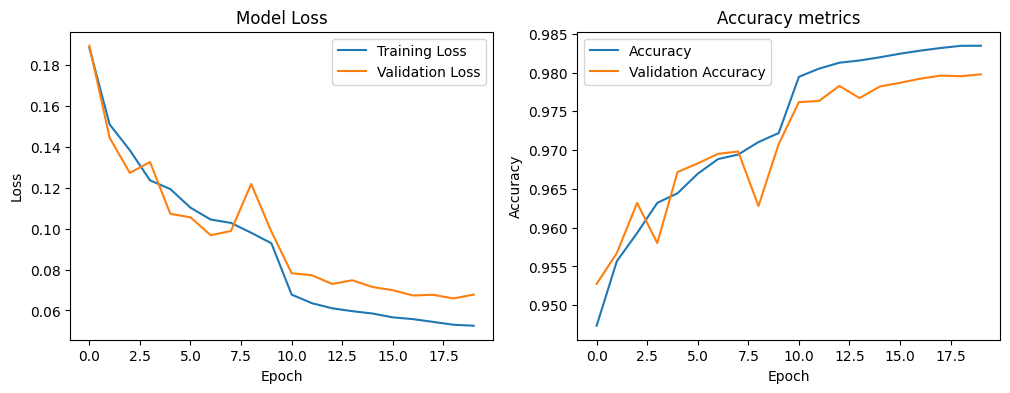

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()